In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
os.listdir('./data/')

['right', 'bed', 'wow', 'stop', 'bird', 'seven', 'up', 'yes']

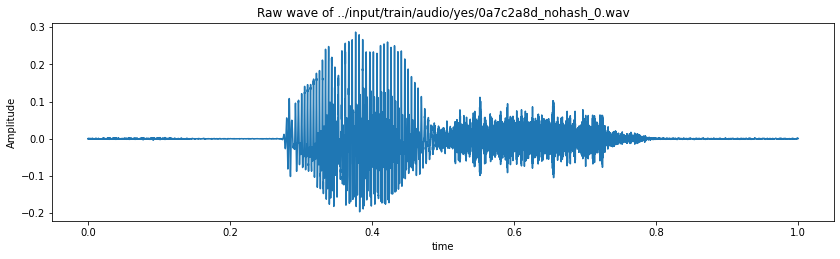

In [3]:
train_audio_path = './data/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [5]:
sample_rate

16000

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [7]:
labels=os.listdir(train_audio_path)

In [8]:
labels=["right", "bed", "wow", "stop", "bird", "seven", "up", "yes"]

In [9]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

right
bed
wow
stop
bird
seven
up
yes


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [11]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [12]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [13]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [14]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 12198 samples, validate on 3050 samples
Epoch 1/10
12198/12198 [==============================] - 82s 7ms/step - loss: 1.8383 - accuracy: 0.2880 - val_loss: 1.5982 - val_accuracy: 0.3721
Epoch 2/10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


12198/12198 [==============================] - 81s 7ms/step - loss: 1.3555 - accuracy: 0.4906 - val_loss: 1.1249 - val_accuracy: 0.5797
Epoch 3/10
12198/12198 [==============================] - 87s 7ms/step - loss: 1.0749 - accuracy: 0.6061 - val_loss: 0.9853 - val_accuracy: 0.6610
Epoch 4/10
12198/12198 [==============================] - 85s 7ms/step - loss: 0.8671 - accuracy: 0.6962 - val_loss: 0.7573 - val_accuracy: 0.7787
Epoch 5/10
12198/12198 [==============================] - 86s 7ms/step - loss: 0.7241 - accuracy: 0.7502 - val_loss: 0.6281 - val_accuracy: 0.7977
Epoch 6/10
12198/12198 [==============================] - 87s 7ms/step - loss: 0.6175 - accuracy: 0.7957 - val_loss: 0.5311 - val_accuracy: 0.8403
Epoch 7/10
12198/12198 [==============================] - 73s 6ms/step - loss: 0.5541 - accuracy: 0.8142 - val_loss: 0.4498 - val_accuracy: 0.8607
Epoch 8/10
12198/12198 [==============================] - 73s 6ms/step - loss: 0.5147 - accuracy: 0.8273 - val_loss: 0.4707 - val

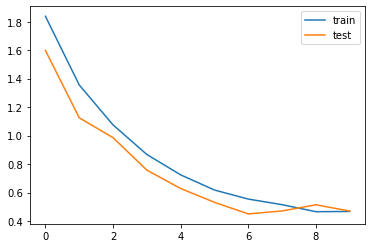

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [21]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [22]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: yes


In [23]:
print("Text:",predict(samples))

Text: yes
